In [1]:
using PyPlot
using DSP
using QuadGK

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [37]:
const t = 0.5
U = 3.0
T = 20.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-16.0,16.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.50;
kB = 8.617333262145e-5;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("cubic",t,ω);

  0.518864 seconds (1.74 M allocations: 123.453 MiB, 6.32% gc time)


In [99]:
function ipt_solver(Aw, nf, U)
    Ap = Aw[:,1] .* nf
    Am = Aw[:,2] .* nf
    App = conv_same(Ap,Ap)
    Appp = conv_same(Am, App)
    return -π .* U^2 .* (Appp + Appp[end:-1:1])

    return -π .* U^2 .* (AAB + BBA)
end

function ipt_selfcons(ω,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        gloc = zeros(ComplexF64,nω,2)
        g0 = zeros(ComplexF64,nω,2)
        isi = zeros(Float64,nω,2)
        hsi = zeros(Float64,nω,2)
        A0 = zeros(Float64,nω,2)
        Σ2 = zeros(ComplexF64,nω,2)

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.9 -0.9]
    
        for i = 1:nω
            ζ_up = zeta(ω[i] - Σ1[1],η)
            ζ_down = zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            @fastmath @inbounds for i in 1:2
                ncalc[i] = -1/π .* trapz(ω,imag(gloc[:,i]) .* nf)
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:2 A0[:,i] = -imag(g0[:,i]) ./ π end
        
            for i = 1:2
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                #println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ2,magnet

end;

In [100]:
function OF_solver(ω,D0ω,g_loc,Σipt,magnet,Nd,Nωn,Nω,U,T,zeroplus,tol,mix,itermax)

ncalc = [-magnet, magnet]
Σ1 = U .* ncalc
Σ1 = reshape(Σ1,1,2)
    
ρr = D0ω[1:4:nω]
wr  = ω[1:4:nω]
    
Σcalc_r = Σipt

g_iωn = zeros(ComplexF64,nωn,2)
for iω in 1:nωn
    ζ = im .* ωn[iω]
        
    intg =  imag(g_loc[:,1]) ./ (ζ .- ω)
    g_iωn[iω,1] = - trapz(ω,intg) / π
    intg =  imag(g_loc[:,2]) ./ (ζ .- ω)
    g_iωn[iω,2] = - trapz(ω,intg) / π
end
    
Σcalc_iωn = zeros(ComplexF64,nωn,2)
for iω in 1:nωn
    ζ = im .* ωn[iω]
        
    intg =  imag(Σipt[:,1]) ./ (ζ .- ω)
    Σcalc_iωn[iω,1] = - trapz(ω,intg) / π
    intg =  imag(Σipt[:,2]) ./ (ζ .- ω)
    Σcalc_iωn[iω,2] = - trapz(ω,intg) / π
end

nf = fermi.(ω,T)
        
df,wd = zeros(Float64,2,Nd),zeros(Float64,Nd)

Σloc_iωn = zeros(Float64,2)
Glocs = zeros(ComplexF64,nωn,2,Nd,Nd)
Seff = zeros(ComplexF64,Nd,Nd)
P = zeros(Float64,Nd,Nd)
Z = 0.0
Gave = zeros(ComplexF64,nωn,2)
    
magnet = 0.0

Σloc = zeros(Float64,2)
Σcalc_r = zeros(ComplexF64,nω,2)
Glocs_r = zeros(ComplexF64,nω,2,Nd,Nd)
        
dx,wd = QuadGK.gauss(Nd)
wdx = wd * transpose(wd)
for i = 1:2
    df[i,:] = sign(vec([1.0 -1.0])[i] ./ U) .* dx
end

for m_iter in 1:25
            
    giωn_old = deepcopy(g_iωn)
    Σcalciωn_old = deepcopy(Σcalc_iωn)

    Σωn_fluc = Σcalc_iωn
    
    gmf_iωn = 1. ./ ( (1. ./ g_iωn) .+ Σ1 .+ Σωn_fluc)
    
    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])

        Σloc_iωn[1] = 0.5 * U .* (ncalc[2].+ dfn2)
        Σloc_iωn[2] = 0.5 * U .* (ncalc[1].+ dfn1)
        Σloc_iωn = reshape(Σloc_iωn,1,2)

        Glocsinv = (1. ./ gmf_iωn) .- Σloc_iωn .- Σωn_fluc

        determ = gmf_iωn .* Glocsinv
        determ = determ[:,1] .* determ[:,2]

        Seff[iNd1,iNd2] = -sum(log.(determ))

        Glocs[:,:,iNd1,iNd2] = 1. ./ Glocsinv

        end
    end
    
    P = exp.(-real.(Seff .- minimum(real.(Seff))))
    Z = sum(P .* wdx)
    
    Gave = zeros(ComplexF64,size(g_iωn))
    @fastmath @inbounds for i = 1:nωn
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P[:,:] .* Glocs[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z
    
    Σcalc_iωn = 1. ./ gmf_iωn .- 1. ./ Gave
    
    Σcalc_iωn = 0. .+ im .* imag(Σcalc_iωn)

    @fastmath @inbounds for (iωn,ωnx) in enumerate(ωn)
        ζup = im*ωn[iωn] - Σ1[1] - Σcalc_iωn[iωn,1]
        ζdw = im*ωn[iωn] - Σ1[2] - Σcalc_iωn[iωn,2]
                
        intg = ρr ./ (ζup*ζdw .- wr.^2.)
        sum = trapz(wr,intg) 
                
        g_iωn[iωn,1] = sum * ζdw
        g_iωn[iωn,2] = sum * ζup
    end
        
    #real iteration ####################################################################
        
    for r_iter = 1:1
    #global Σloc

    gloc_old = deepcopy(g_loc)

    Σ_fluc = Σcalc_r

    gmf = 1. ./ ( (1. ./ g_loc) .+ Σ_fluc .+ Σ1)

    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])
            Σloc[1] = 0.5 * U .* (ncalc[2] .+ dfn2)
            Σloc[2] = 0.5 * U .* (ncalc[1] .+ dfn1)
            Σloc = reshape(Σloc,1,2)

            Glocs_r[:,:,iNd1,iNd2] = 1 ./ ( (1. ./ gmf) .- Σloc .- Σ_fluc)
        end
    end

    Gave = zeros(ComplexF64,size(g_loc))
    @fastmath @inbounds for i = 1:nω
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P .* Glocs_r[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z;

    Σcalc_r = 1 ./ gmf .- 1 ./ Gave;
    Σcalc_r = Σcalc_r
        
    hsi = zeros(Float64,size(Σcalc_r))    
    for i in 1:2 hsi[:,i] = imag.(Util.hilbert(imag(Σcalc_r[:,i]))) end
        
    Σcalc_r = hsi .+ im .* imag(Σcalc_r)
        

    @fastmath @inbounds for i = 1:nω
        ζup = ω[i] + im * zeroplus - Σ1[1] - Σcalc_r[i,1]
        ζdw = ω[i] + im * zeroplus - Σ1[2] - Σcalc_r[i,2]
    
        intg = ρr ./ (ζup*ζdw .- wr.^2)
        sum = trapz(wr,intg)
    
        g_loc[i,1] = sum * ζdw
        g_loc[i,2] = sum * ζup
    end

    ncalc = zeros(Float64,2)
    @fastmath @inbounds for i in 1:2
        ncalc[i] = -1/π .* trapz(ω,imag(g_loc[:,i]) .* nf)
    end
    
    Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
    Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
    magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
            
    @fastmath @inbounds for iω in 1:nω
        ζ_up = ω[iω] + im * zeroplus - Σ1[1] - Σcalc_r[iω,1]
        ζ_down = ω[iω] + im * zeroplus - Σ1[2] - Σcalc_r[iω,2]

        intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
        sum = trapz(wr,intg)   

        g_loc[iω,1] = sum * ζ_down
        g_loc[iω,2] = sum * ζ_up
    end

    convg, error = convergent(gloc_old,g_loc,ω,nω,tol)
    
    if convg==true
        break
    end

    end
        
    #real iteration ####################################################################
        
    ncalc[1] = ncalc[1] - sum(ncalc)
    ncalc[2] = ncalc[2] - sum(ncalc)
    
    convg, error = convergent(giωn_old,g_iωn,ωn,nωn,tol)
    
    if convg==true || m_iter==25
        break
    end
    
end
    
    return g_iωn, Σcalc_iωn, P, g_loc, Σcalc_r, magnet

end

OF_solver (generic function with 1 method)

In [101]:
function ofplusipt(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
    glocipt,Σipt,magnet =  ipt_selfcons(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
    glociptx = deepcopy(glocipt)
    Σiptx = deepcopy(Σipt)
    magnetx = deepcopy(magnet)
    
    _,_,P,glocr,Σr,magnetofipt = OF_solver(ω,D0ω,glocipt,Σipt,magnet,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax)
    println("Done for U = $U eV and T = $T K")
    
    return P,glocr,Σr,magnetofipt,glociptx,Σiptx,magnetx
end

ofplusipt (generic function with 1 method)

In [52]:
T = 150.
Us = [1.0, 1.5, 2.0, 2.5, 4.0, 4.5]
Us = convert(Array{Float64},Us)

PU = zeros(Float64,Nd,Nd,length(Us))
glocrU = zeros(ComplexF64,nω,2,length(Us))
ΣrU = zeros(ComplexF64,nω,2,length(Us))
magnetofiptU = zeros(Float64,length(Us))

glociptU = zeros(ComplexF64,nω,2,length(Us))
Σ2iptU = zeros(ComplexF64,nω,2,length(Us))
magnetiptU = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    PU[:,:,iU],glocrU[:,:,iU],ΣrU[:,:,iU],magnetofiptU[iU],
    glociptU[:,:,iU],Σ2iptU[:,:,iU],magnetiptU[iU] = 
    ofplusipt(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
end

Convergent is achieved for U = 1.0, and T = 150.0 K
Done for U = 1.0 eV and T = 150.0 K
Convergent is achieved for U = 1.5, and T = 150.0 K
Done for U = 1.5 eV and T = 150.0 K
Convergent is achieved for U = 2.0, and T = 150.0 K
Done for U = 2.0 eV and T = 150.0 K
Convergent is achieved for U = 2.5, and T = 150.0 K
Done for U = 2.5 eV and T = 150.0 K
Convergent is achieved for U = 4.0, and T = 150.0 K
Done for U = 4.0 eV and T = 150.0 K
Convergent is achieved for U = 4.5, and T = 150.0 K
Done for U = 4.5 eV and T = 150.0 K


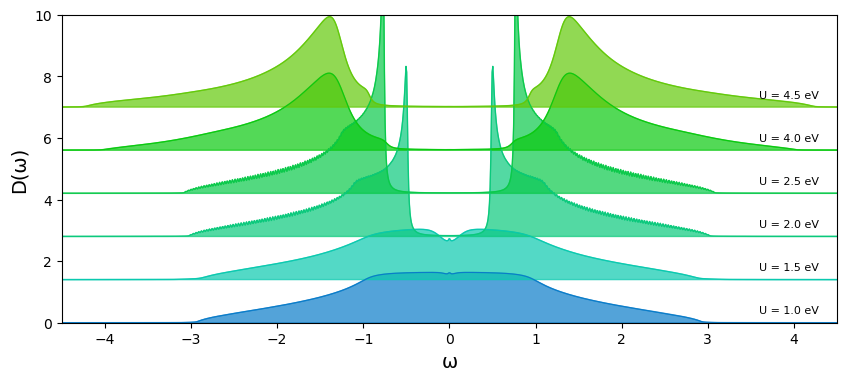

In [74]:
plt.figure(figsize=(10,4))
color = ["#0A7CC9","#0AC9AF","#0AC97C","#0AC94A","#0AC910","#63C90A"]
dashtype = ["-","-","--","-.",":"]
for (iU,U) in enumerate(Us)
    plt.plot(ω,-imag(sum(glocrU[:,:,iU],dims=2)) .+ 1.4*(iU - 1),color=color[iU],linewidth=0.8)
    plt.text(3.6,(iU-1)* 1.4 + 0.3,"U = $U eV",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocrU[:,:,iU],dims=2)).+ (iU-1)*1.4),(iU-1)*1.4,alpha=0.7,color=color[iU])
end
plt.xlim(-4.5,4.5)
plt.ylim(0,10.0)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolUDOS_OFIPT_AF.pdf",format="pdf")

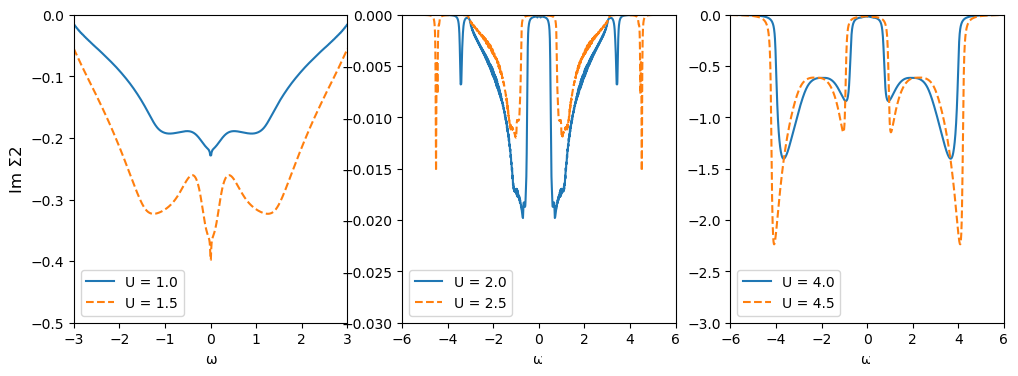

In [185]:
dashtype = ["-","--",":","-.","--",":"]
Us = [1.0, 1.5, 2.0, 2.5, 4.0, 4.5]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
for iU in 1:2
    plt.plot(ω,imag(sum(ΣrU[:,:,iU],dims=2)),dashtype[iU],label="U = $(Us[iU])")
end
plt.ylim(-0.5,0)
plt.xlim(-3,3)
plt.ylabel("Im Σ2",fontsize=12)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,3,2)
for iU in 3:4
    plt.plot(ω,imag(sum(ΣrU[:,:,iU],dims=2)),dashtype[iU-2],label="U = $(Us[iU])")
end
plt.ylim(-0.03,0)
plt.xlim(-6,6)
plt.xlabel("ω")
plt.legend()

plt.subplot(1,3,3)
for iU in 5:6
    plt.plot(ω,imag(sum(ΣrU[:,:,iU],dims=2)),dashtype[iU-4],label="U = $(Us[iU])")
end
plt.ylim(-3.0,0)
plt.xlim(-6,6)
plt.xlabel("ω")
plt.legend()

plt.show()
plt.savefig("evolUΣ2_OFIPT_AF.pdf",format="pdf")

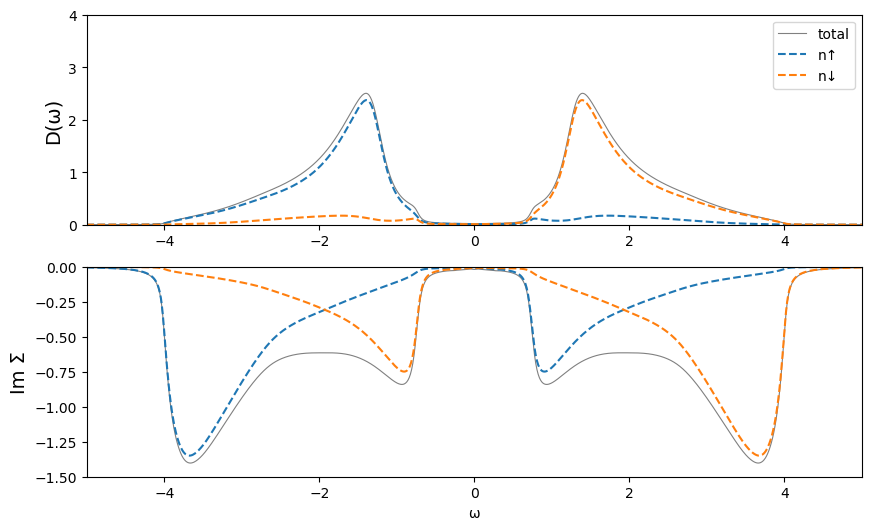

In [97]:
Σ1 = U * magnetofiptU[3]

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(ω,-imag(sum(glocrU[:,:,5],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,-imag(glocrU[:,1,5]),"--",label="n↑")
plt.plot(ω,-imag(glocrU[:,2,5]),"--",label="n↓")
plt.xlim(-5,5)
plt.ylim(0,4)
plt.ylabel("D(ω)",fontsize=14)
plt.legend()

plt.subplot(2,1,2)
plt.plot(ω,imag(sum(ΣrU[:,:,5],dims=2)),color="grey",linewidth=0.8,label="total")
plt.plot(ω,imag(ΣrU[:,1,5]),"--",label="total")
plt.plot(ω,imag(ΣrU[:,2,5]),"--",label="total")
plt.xlim(-5,5)
plt.ylim(-1.5,0)
plt.ylabel("Im Σ",fontsize=14)
plt.xlabel("ω")

plt.show()
plt.savefig("dosupdown_OFIPT_AF.pdf",format="pdf")

In [128]:
U = 1.8
Ts = [200., 250., 500., 800., 1500., 2500., 5000.,]
Ts = convert(Array{Float64},Ts)

PT = zeros(Float64,Nd,Nd,length(Ts))
glocrT = zeros(ComplexF64,nω,2,length(Ts))
ΣrT = zeros(ComplexF64,nω,2,length(Ts))
magnetofiptT = zeros(Float64,length(Ts))

glociptT = zeros(ComplexF64,nω,2,length(Ts))
Σ2iptT = zeros(ComplexF64,nω,2,length(Ts))
magnetiptT = zeros(Float64,length(Ts))

for (iT,T) in enumerate(Ts)
    PT[:,:,iT],glocrT[:,:,iT],ΣrT[:,:,iT],magnetofiptT[iT],
    glociptT[:,:,iT],Σ2iptT[:,:,iT],magnetiptT[iT] = 
    ofplusipt(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
end

Done for U = 1.8 eV and T = 200.0 K
Done for U = 1.8 eV and T = 250.0 K
Done for U = 1.8 eV and T = 500.0 K
Done for U = 1.8 eV and T = 800.0 K
Done for U = 1.8 eV and T = 1500.0 K
Done for U = 1.8 eV and T = 2500.0 K
Done for U = 1.8 eV and T = 5000.0 K


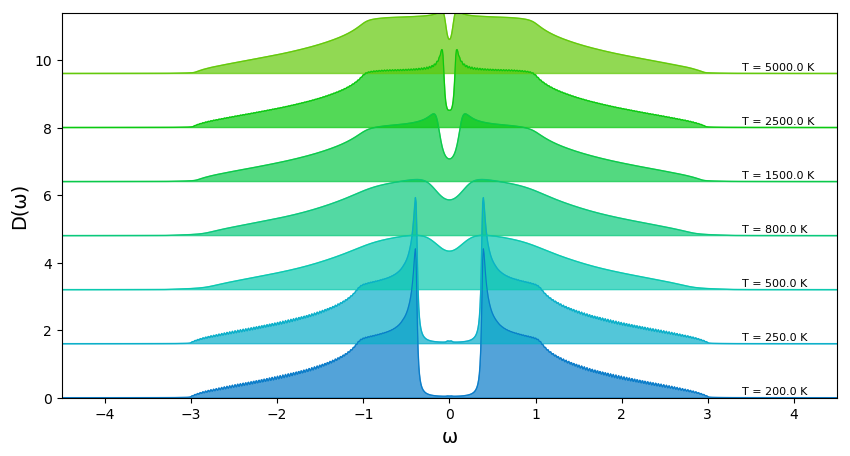

In [129]:
plt.figure(figsize=(10,5))
color = ["#0A7CC9","#0AAFC9","#0AC9AF","#0AC97C","#0AC94A","#0AC910","#63C90A"]
dashtype = ["-","--","-.",":"]
for (iT,T) in enumerate(Ts)
    plt.plot(ω,-imag(sum(glocrT[:,:,iT],dims=2)) .+ 1.6*(iT - 1),color=color[iT],linewidth=0.8)
    plt.text(3.4,(iT-1)*1.6 + 0.1,"T = $T K",fontsize=8)
    plt.fill_between(ω,vec(-imag(sum(glocrT[:,:,iT],dims=2)).+ (iT-1)*1.6),(iT-1)*1.6,alpha=0.7,color=color[iT])
end
plt.xlim(-4.5,4.5)
plt.ylim(0,11.4)
plt.xlabel("ω",fontsize=14)
plt.ylabel("D(ω)",fontsize=14)

plt.show()

plt.savefig("evolTDOS_OFIPT_AF.pdf",format="pdf")

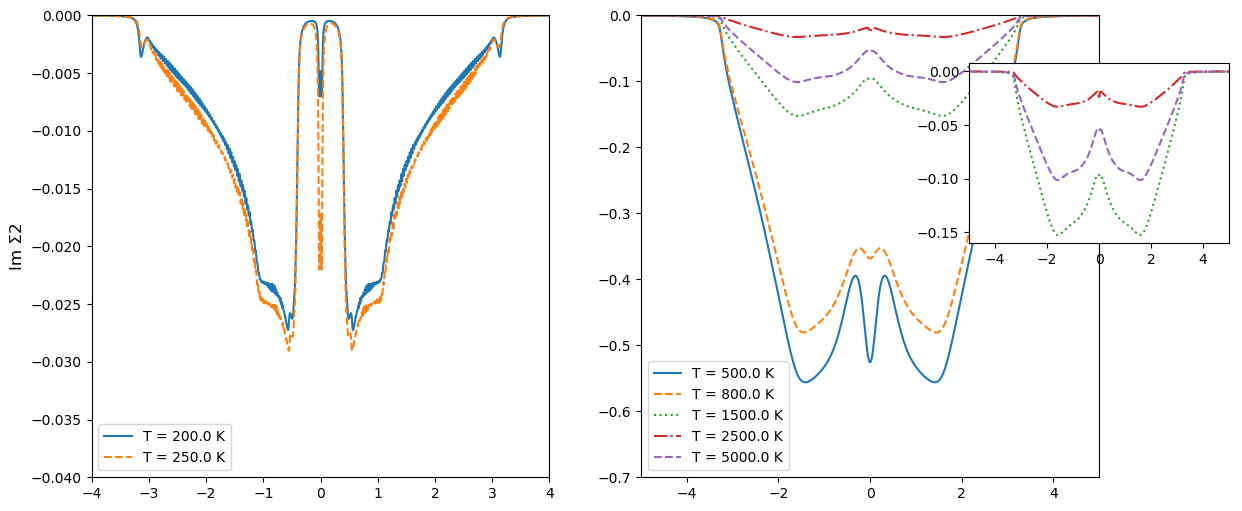

In [182]:
dashtype = ["-","--",":","-.","--",":"]
Ts = [200., 250., 500., 800., 1500., 2500., 5000.,]

fig = plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
for iT in 1:2
    plt.plot(ω,imag(sum(ΣrT[:,:,iT],dims=2)),dashtype[iT],label="T = $(Ts[iT]) K")
end
plt.ylim(-0.04,0)
plt.xlim(-4,4)
plt.ylabel("Im Σ2",fontsize=12)
plt.legend()

plt.subplot(1,2,2)
for iT in 3:7
    plt.plot(ω,imag(sum(ΣrT[:,:,iT],dims=2)),dashtype[iT-2],label="T = $(Ts[iT]) K")
end
plt.ylim(-0.7,0)
plt.xlim(-5,5)
plt.legend()

colors = ["#2ca02c","#d62728","#9467bd"]
ax1 = fig.add_axes([0.8, 0.5, 0.20, 0.3])
for iT in 5:7
    ax1.plot(ω,imag(sum(ΣrT[:,:,iT],dims=2)),dashtype[iT-2],color = colors[iT-4],label="T = $(Ts[iT]) K")
end
plt.xlim(-5,5)

plt.show()
plt.savefig("evolTΣ2_OFIPT_AF.pdf",format="pdf")

In [186]:
T = 100.

Us = range(0.8,length=20,step=0.3)
Us = convert(Array{Float64},Us)

magnetofiptU = zeros(Float64,length(Us))
magnetiptU = zeros(Float64,length(Us))

for (iU,U) in enumerate(Us)
    _,_,_,magnetofiptU[iU],_,_,magnetiptU[iU] = 
    ofplusipt(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
end

Done for U = 0.8 eV and T = 100.0 K
Done for U = 1.1 eV and T = 100.0 K
Done for U = 1.4 eV and T = 100.0 K
Done for U = 1.7 eV and T = 100.0 K
Done for U = 2.0 eV and T = 100.0 K
Done for U = 2.3 eV and T = 100.0 K
Done for U = 2.6 eV and T = 100.0 K
Done for U = 2.9 eV and T = 100.0 K
Done for U = 3.2 eV and T = 100.0 K
Done for U = 3.5 eV and T = 100.0 K
Done for U = 3.8 eV and T = 100.0 K
Done for U = 4.1 eV and T = 100.0 K
Done for U = 4.4 eV and T = 100.0 K
Done for U = 4.7 eV and T = 100.0 K
Done for U = 5.0 eV and T = 100.0 K
Done for U = 5.3 eV and T = 100.0 K
Done for U = 5.6 eV and T = 100.0 K
Done for U = 5.9 eV and T = 100.0 K
Done for U = 6.2 eV and T = 100.0 K
Done for U = 6.5 eV and T = 100.0 K


In [190]:
U = 2.5

Ts = range(0.0,length=20,stop = 2500.)
Ts = convert(Array{Float64},Ts)

magnetofiptT = zeros(Float64,length(Us))
magnetiptT = zeros(Float64,length(Us))

for (iT,T) in enumerate(Ts)
    _,_,_,magnetofiptT[iT],_,_,magnetiptT[iT] = 
    ofplusipt(ω,D0ω,t,U,T,itermax,nω,zeroplus,mix,tol)
end

Done for U = 2.5 eV and T = 0.0 K
Done for U = 2.5 eV and T = 131.57894736842104 K
Done for U = 2.5 eV and T = 263.1578947368421 K
Done for U = 2.5 eV and T = 394.7368421052632 K
Done for U = 2.5 eV and T = 526.3157894736842 K
Done for U = 2.5 eV and T = 657.8947368421053 K
Done for U = 2.5 eV and T = 789.4736842105264 K
Done for U = 2.5 eV and T = 921.0526315789474 K
Done for U = 2.5 eV and T = 1052.6315789473683 K
Done for U = 2.5 eV and T = 1184.2105263157894 K
Done for U = 2.5 eV and T = 1315.7894736842106 K
Done for U = 2.5 eV and T = 1447.3684210526317 K
Done for U = 2.5 eV and T = 1578.9473684210527 K
Done for U = 2.5 eV and T = 1710.5263157894738 K
Done for U = 2.5 eV and T = 1842.1052631578948 K
Done for U = 2.5 eV and T = 1973.6842105263158 K
Done for U = 2.5 eV and T = 2105.2631578947367 K
Done for U = 2.5 eV and T = 2236.842105263158 K
Done for U = 2.5 eV and T = 2368.4210526315787 K
Done for U = 2.5 eV and T = 2500.0 K


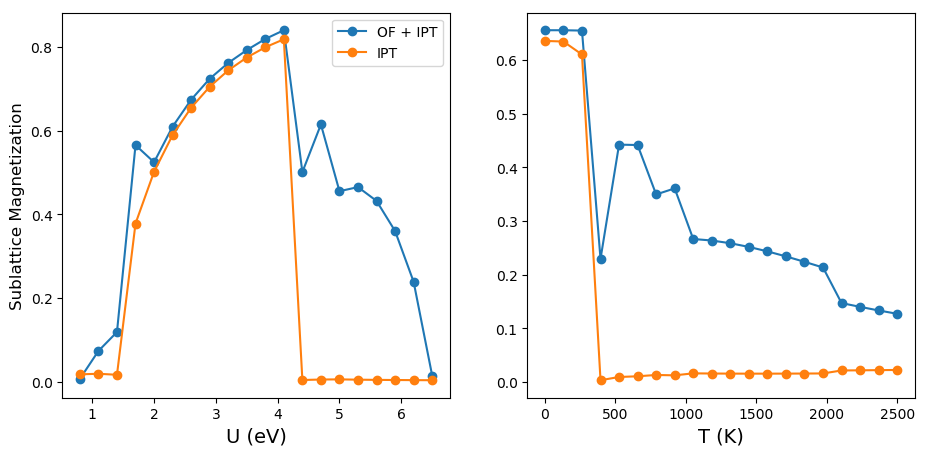

In [194]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.plot(Us,abs.(magnetofiptU),"-o",label="OF + IPT")
plt.plot(Us,abs.(magnetiptU),"-o",label="IPT")
plt.ylabel("Sublattice Magnetization",fontsize=12)
plt.xlabel("U (eV)",fontsize=14)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Ts,abs.(magnetofiptT),"-o")
plt.plot(Ts,abs.(magnetiptT),"-o")
plt.xlabel("T (K)",fontsize=14)

plt.show()
plt.savefig("magnetization_OFIPT_AF.pdf",format="pdf")